Before anything else, the first thing to do is understand the project and the problem at hand. In this project, our main focus is to use the provided customer and transaction data to predict the likelihood of customer churn. To go through the process, we have to:
- Clean the data
- Define our problem
- Explore the data
- Feature Engineering
- Model selection
- Model Training/Testing



First thing is to load up the modules we'll be using for the project


In [1]:
import pandas as pd
import seaborn as sns                           
import numpy as np                               
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime

## 1. **Data Cleansing**
Load the data from the provided files

In [2]:
customers_filepath=r'C:/Users/Kevin/Bench Projects/bankingchurn/data/customers_tm1_e.csv'
transactions_filepath=r'C:/Users/Kevin/Bench Projects/bankingchurn/data/transactions_tm1_e.csv'

customer_df=pd.read_csv(customers_filepath)
transactions_df=pd.read_csv(transactions_filepath)

Conduct preliminary data cleansing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116016 entries, 0 to 116015
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    116016 non-null  int64  
 1   dob            116016 non-null  object 
 2   state          116016 non-null  object 
 3   start_balance  116013 non-null  float64
 4   creation_date  116016 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.4+ MB


<AxesSubplot:>

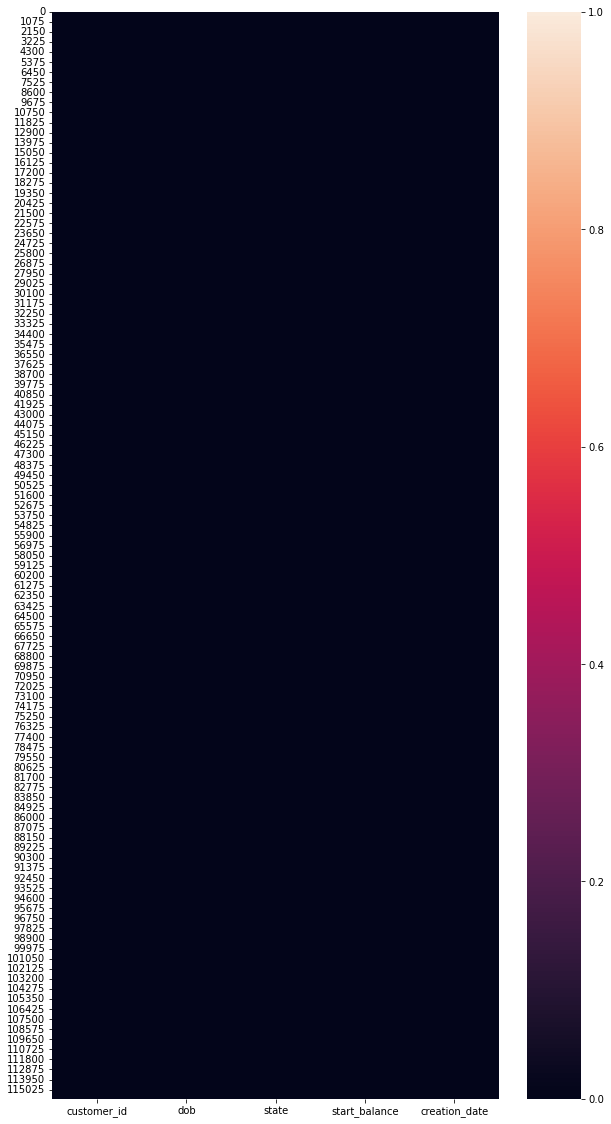

In [3]:
customer_df.info()                                 #see the details of the data frame

missing=customer_df.isna()                         #heatmap for a first glance of data. Useful to visual missing data
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(missing, ax=ax)

Because a vast majority of data is present and a fraction of a percent of data is incomplete, we can choose to remove it from the dataset without affecting the quality of the data. Another option is to perform imputation, however, it wouldn't make sense impute the start_balance data as it can cause issues later down the line when conducting feature engineering. 

In [4]:
customer_df=customer_df.dropna(axis=0)              #gets rid of all rows with a N/A value
customer_df.info()                                  #checks the result 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 116013 entries, 0 to 116015
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    116013 non-null  int64  
 1   dob            116013 non-null  object 
 2   state          116013 non-null  object 
 3   start_balance  116013 non-null  float64
 4   creation_date  116013 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.3+ MB


Summary Statistics

In [5]:
customer_df.describe()                              ##used to check for outliers in dataset and overall information

,customer_id,start_balance
count,116013.000000,1.160130e+05
mean,58098.594382,-5.381404e+04
std,33491.133795,3.008448e+07
min,91.000000,-1.000000e+10
25%,29095.000000,3.157720e+03
50%,58099.000000,6.297440e+03
75%,87102.000000,9.511160e+03
max,116106.000000,2.000000e+09


Check and corrects for regularity in the data

In [6]:
customer_df['state'].value_counts()                                               #checks to see if there are anything irregular about data. Sees that there are duplicate values/abbreviated 
state_dict={'state':{'NY':'New York','MASS':'Massachusetts','CALIFORNIA':'California','TX':'Texas'}}
customer_df=customer_df.replace(state_dict)                                       #corrects the data that could be used
mask=customer_df.isin(['-999','Australia','UNK'])
customer_df=customer_df[~mask]                                                    #keeps all the usable data and forgoes the rest
customer_df['state'].value_counts()

customer_df['start_balance'].value_counts().sort_index(ascending=True)            #checks to see if there are anything irregular about data. Sees a negative starting balance 
mask=customer_df['start_balance']>=0                                              #removes outliers of a negative balance 
customer_df=customer_df[mask]
mask=customer_df['start_balance']<10000000                                        #removes obvious outliers
customer_df=customer_df[mask]
customer_df['start_balance'].value_counts().sort_index(ascending=True) 

customer_df['creation_date'].value_counts().sort_index(ascending=True)            #doesn't seem to have any irregularites 
customer_df['customer_id'].value_counts().sort_index(ascending=True)
customer_df['dob'].value_counts().sort_index(ascending=True)

1941-04-01    1
1941-05-25    1
1941-09-02    1
1941-11-29    1
1942-01-28    1
             ..
1999-12-05    1
1999-12-08    2
1999-12-13    1
1999-12-15    1
1999-12-17    1
Name: dob, Length: 17580, dtype: int64

Doesn't seem to be any missing data for the transaction data

In [7]:
transactions_df.info(verbose=True,show_counts=True)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4977972 entries, 0 to 4977971
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              4977972 non-null  object 
 1   account_id        4977972 non-null  int64  
 2   customer_id       4977972 non-null  int64  
 3   amount            4977972 non-null  float64
 4   transaction_date  4977972 non-null  object 
 5   deposit           4977972 non-null  float64
 6   withdrawal        4977972 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 265.9+ MB


Summary Statistics 

In [8]:
transactions_df.describe()                              #used to check for outliers in dataset and overall information

,account_id,customer_id,amount,deposit,withdrawal
count,4.977972e+06,4.977972e+06,4.977972e+06,4.977972e+06,4.977972e+06
mean,2.419243e+07,5.457818e+04,-1.794271e+04,6.683949e+02,-6.399419e+02
std,3.202508e+04,3.202508e+04,1.526698e+07,1.155295e+03,1.206452e+03
min,2.413795e+07,9.100000e+01,-1.000000e+10,0.000000e+00,-1.678565e+04
25%,2.416379e+07,2.593500e+04,-7.501900e+02,0.000000e+00,-7.501800e+02
50%,2.419477e+07,5.691200e+04,-2.631000e+01,0.000000e+00,-2.631000e+01
75%,2.421996e+07,8.210300e+04,1.042163e+03,1.042160e+03,0.000000e+00
max,2.425396e+07,1.161060e+05,2.934292e+09,9.888510e+03,0.000000e+00


Check and corrects data for any irregularities

In [9]:
transactions_df['amount'].value_counts().sort_index(ascending=True)                         #removes outliers
mask=transactions_df['amount']>-1000000
transactions_df=transactions_df[mask]
mask=transactions_df['amount']<1000000
transactions_df=transactions_df[mask]
transactions_df['amount'].value_counts().sort_index(ascending=True)  

transactions_df['deposit'].value_counts().sort_index(ascending=True)                        #doesn't seem to have any irregularities
transactions_df['withdrawal'].value_counts().sort_index(ascending=True)
transactions_df['date'].value_counts().sort_index(ascending=True)
transactions_df['account_id'].value_counts().sort_index(ascending=True)

24137947     6
24137948    31
24137949    29
24137950    33
24137951    47
            ..
24253958     2
24253959     3
24253960     2
24253961     1
24253962     1
Name: account_id, Length: 116016, dtype: int64

## 2. **Define our problem**

With our goal of trying to predict the probability of customer churn, we first have to define what customer churn is. By doing research on what churning is or by asking experts in the domain, we're able to identify churn to be when a customer has stopped using your product or service during a certain time frame. The service/product of the project is the saving account and the time frame is from when the dataset start and ends. Because the dataset does not have something defining the definition of churn, we'd have to manufacture one.

In [10]:
last_trans_date=transactions_df.groupby(['customer_id'])['date'].last()                                 #creates a reference column for churn 
customer_df=pd.merge(customer_df,last_trans_date,how='inner',on='customer_id')
customer_df=customer_df.rename(columns={'date':'last_date'})


def closed_acc(row):
    if datetime.strptime(row['last_date'], '%Y-%m-%d')<datetime.strptime('2020-05-31', '%Y-%m-%d'):     #if the last transaction date is earlier than the last recorded date, it's churned
        return 1
    else:
        return 0
customer_df['closed_acc']=customer_df.apply(closed_acc,axis=1)                                          #applies formula to every row 
display(customer_df)

,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc
0,91,1993-07-01,California,10180.56,2007-01-31,2007-03-31,1
1,92,1985-12-05,New York,4757.68,2007-01-31,2008-03-31,1
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,2007-11-30,1
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,2007-10-31,1
4,95,1970-04-06,California,12500.72,2007-01-31,2008-08-31,1
...,...,...,...,...,...,...,...
116005,116102,1969-03-02,Georgia,3110.96,2020-05-31,2020-05-31,0
116006,116103,1966-10-25,New York,12063.92,2020-05-31,2020-05-31,0
116007,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,2020-05-31,0
116008,116105,1983-08-25,New Mexico,8861.08,2020-05-31,2020-05-31,0


Much of the data as of current can't really be used to look at the relationship between other data points. Let's transform the data into usable state

In [11]:
def calculate_age(born):
    today=datetime.strptime('2020-05-31', '%Y-%m-%d')
    born['dob']=datetime.strptime(born['dob'], '%Y-%m-%d')
    return today.year - born['dob'].year - ((today.month, today.day) < (born['dob'].month, born['dob'].day))
customer_df['cust_age']=customer_df.apply(calculate_age,axis=1)                                                 #uses their dob to determine their age

last_trans_date=transactions_df.groupby(['customer_id'])['date'].last()
customer_df=pd.merge(customer_df,last_trans_date,how='inner',on='customer_id')
customer_df=customer_df.rename(columns={'date':'last_trans_date'})
display(customer_df)
def calculate_acc_age_months(born):
    born['last_transaction_date']=datetime.strptime(born['last_trans_date'], '%Y-%m-%d')
    born['creation_date']=datetime.strptime(born['creation_date'], '%Y-%m-%d')
    year_in_months=(born['last_transaction_date'].year-born['creation_date'].year)*12
    months=born['last_transaction_date'].month-born['creation_date'].month
    return year_in_months + months
customer_df['acc_age']=customer_df.apply(calculate_acc_age_months,axis=1)                                       #uses their last transaction date to determine the acc age

,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc,cust_age,last_trans_date
0,91,1993-07-01,California,10180.56,2007-01-31,2007-03-31,1,26,2007-03-31
1,92,1985-12-05,New York,4757.68,2007-01-31,2008-03-31,1,34,2008-03-31
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,2007-11-30,1,32,2007-11-30
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,2007-10-31,1,39,2007-10-31
4,95,1970-04-06,California,12500.72,2007-01-31,2008-08-31,1,50,2008-08-31
...,...,...,...,...,...,...,...,...,...
116005,116102,1969-03-02,Georgia,3110.96,2020-05-31,2020-05-31,0,51,2020-05-31
116006,116103,1966-10-25,New York,12063.92,2020-05-31,2020-05-31,0,53,2020-05-31
116007,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,2020-05-31,0,34,2020-05-31
116008,116105,1983-08-25,New Mexico,8861.08,2020-05-31,2020-05-31,0,36,2020-05-31


## 3. **Data Exploration**

Use the data we currently have to understand the our data, create summary statistics, visual the data, gained domain knowledge, and potentially derive any relationships between the data that could explain our problem

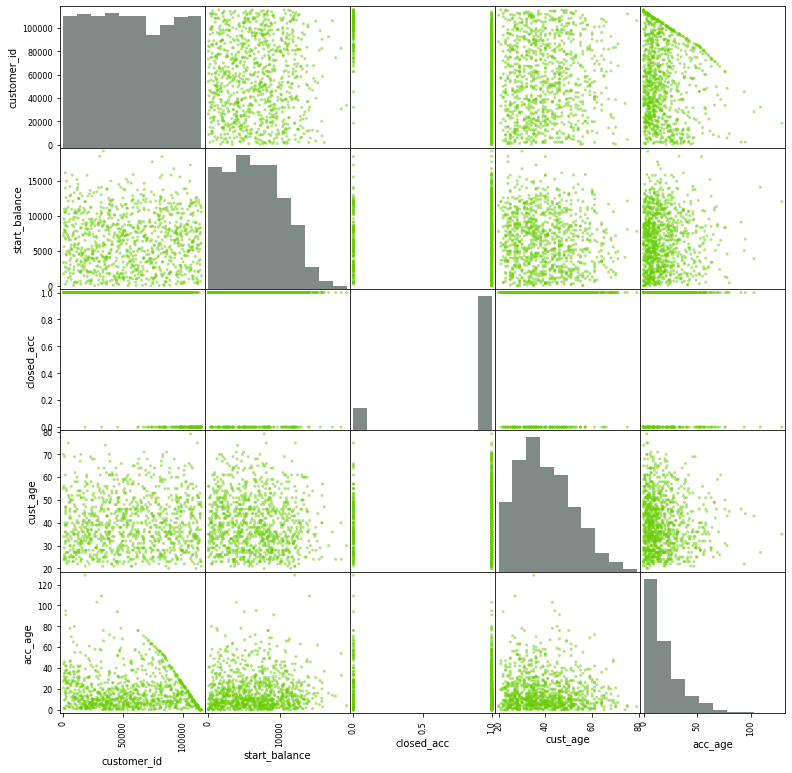

In [12]:
customer_df.corr()


from pandas.plotting import scatter_matrix
features = ['customer_id', 'start_balance', 'closed_acc','cust_age', 'acc_age']
scatter_matrix(customer_df[features].sample(1000), figsize = (13,13), c = '#66CD00', hist_kwds={'color':['#808A87']})
plt.show()

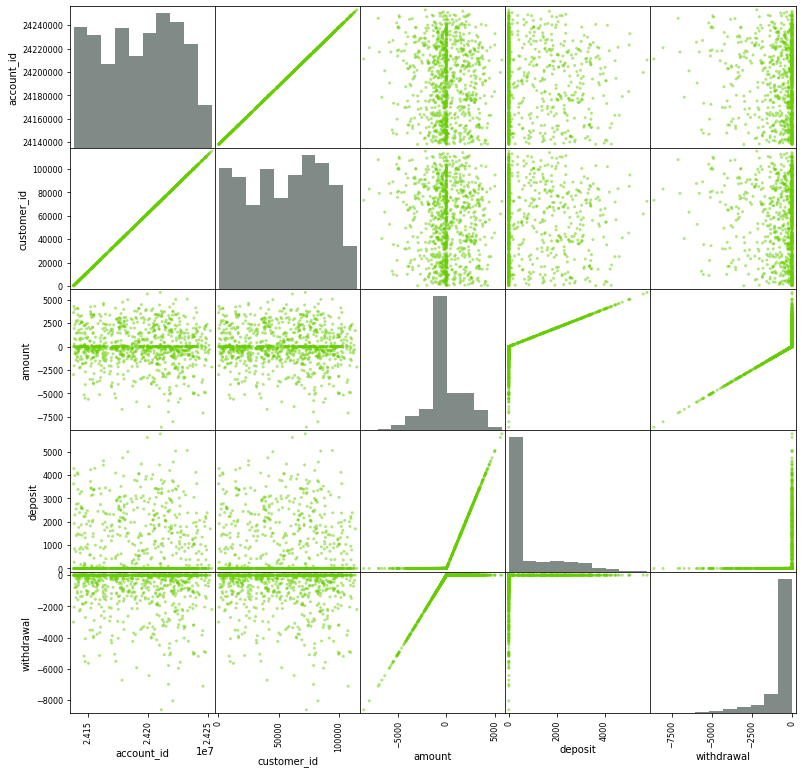

In [13]:
transactions_df.corr()
features = ['account_id', 'customer_id', 'amount', 'deposit','withdrawal']

scatter_matrix(transactions_df[features].sample(1000), figsize = (13,13), c = '#66CD00', hist_kwds={'color':['#808A87']})
plt.show()

From exploring, we can understand the demographic of the users using these savings accounts, value frequencies of transactions, and the distribution of the data

## 4. **Feature Engineering**

Now that we have an idea of how the dataset is like, we can use our understanding to create new features that can potentially explain our churn problem further.

Creates a feature to see the frequency of net positive monthly transactions to trigger savings interest

In [14]:
month_sum=transactions_df.groupby(['customer_id','date'])['amount'].sum()
month_sum=pd.DataFrame(month_sum)
def deposit_interest(row):
    if row['amount']<=0:
        return 0
    else:
        return 1
month_sum['accrued_interest']=month_sum.apply(deposit_interest,axis=1)
freq_accrued_interest=month_sum.groupby(['customer_id'])['accrued_interest'].sum()
customer_df=pd.merge(customer_df,freq_accrued_interest,how='inner', on='customer_id')
display(customer_df)                                                                    


,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc,cust_age,last_trans_date,acc_age,accrued_interest
0,91,1993-07-01,California,10180.56,2007-01-31,2007-03-31,1,26,2007-03-31,2,0
1,92,1985-12-05,New York,4757.68,2007-01-31,2008-03-31,1,34,2008-03-31,14,6
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,2007-11-30,1,32,2007-11-30,10,4
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,2007-10-31,1,39,2007-10-31,9,3
4,95,1970-04-06,California,12500.72,2007-01-31,2008-08-31,1,50,2008-08-31,19,9
...,...,...,...,...,...,...,...,...,...,...,...
116005,116102,1969-03-02,Georgia,3110.96,2020-05-31,2020-05-31,0,51,2020-05-31,0,0
116006,116103,1966-10-25,New York,12063.92,2020-05-31,2020-05-31,0,53,2020-05-31,0,0
116007,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,2020-05-31,0,34,2020-05-31,0,0
116008,116105,1983-08-25,New Mexico,8861.08,2020-05-31,2020-05-31,0,36,2020-05-31,0,1


Creates a reference column for future features

In [15]:
transactions_df['cum_trans']=transactions_df.groupby(['customer_id'])['amount'].cumsum()                #gives cumulative transaction 
transactions_df.head()

def freq_deposit(row):
    if row['deposit']>0:
        return 1
    else:
        return 0                                                                                    
transactions_df['flag_deposit']=transactions_df.apply(freq_deposit, axis=1)
transactions_df['freq_deposit']=transactions_df.groupby(['customer_id'])['flag_deposit'].cumsum()       #flag any deposit transaction
def freq_withdrawal(row):
    if row['withdrawal']<0:
        return 1
    else:
        return 0
transactions_df['flag_withdrawal']=transactions_df.apply(freq_withdrawal, axis=1)
transactions_df['freq_withdrawal']=transactions_df.groupby(['customer_id'])['flag_withdrawal'].cumsum() #flag any deposit transaction
display(transactions_df)

,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal,cum_trans,flag_deposit,freq_deposit,flag_withdrawal,freq_withdrawal
0,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00,3034.26,1,1,0,0
1,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18,-2260.92,0,1,1,1
2,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00,-2260.92,0,1,0,1
3,2007-03-31,24137947,91,-0.00,2007-03-30,0.00,-0.00,-2260.92,0,1,0,1
4,2007-03-31,24137947,91,-0.00,2007-03-11,0.00,-0.00,-2260.92,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4977967,2020-05-31,24253959,116103,-3056.19,2020-05-09,0.00,-3056.19,-1003.22,0,1,1,2
4977968,2020-05-31,24253960,116104,2900.20,2020-05-31,2900.20,0.00,2900.20,1,1,0,0
4977969,2020-05-31,24253960,116104,-4002.30,2020-05-29,0.00,-4002.30,-1102.10,0,1,1,1
4977970,2020-05-31,24253961,116105,2246.93,2020-05-31,2246.93,0.00,2246.93,1,1,0,0


Creates summary transactions feature for each customer. <br>
Average deposit, Total Deposit, Average withdrawal, Total_withdrawal

In [16]:
flagged_deposit_df=transactions_df[transactions_df['flag_deposit']==1]
flagged_deposit_df=flagged_deposit_df.rename(columns={'transaction_date':'last_deposit_date'})


last_deposit_df=flagged_deposit_df.groupby(['customer_id'])['last_deposit_date'].last()
customer_df=pd.merge(customer_df,last_deposit_df,how='inner',on='customer_id')


avg_deposit=flagged_deposit_df.groupby(['customer_id'])['deposit'].mean()
customer_df=pd.merge(customer_df,avg_deposit,how='inner',on='customer_id')
customer_df=customer_df.rename(columns={'deposit':'avg_deposit'})


total_deposit=flagged_deposit_df.groupby(['customer_id'])['deposit'].sum()
customer_df=pd.merge(customer_df,total_deposit,how='inner',on='customer_id')
customer_df=customer_df.rename(columns={'deposit':'total_deposit'})


flagged_withdrawal_df=transactions_df[transactions_df['flag_withdrawal']==1]
flagged_withdrawal_df=flagged_withdrawal_df.rename(columns={'transaction_date':'last_withdrawal_date'})

avg_withdrawal=flagged_withdrawal_df.groupby(['customer_id'])['withdrawal'].mean()
customer_df=pd.merge(customer_df,avg_withdrawal,how='inner',on='customer_id')
customer_df=customer_df.rename(columns={'withdrawal':'avg_withdrawal'})


total_withdrawal=flagged_withdrawal_df.groupby(['customer_id'])['withdrawal'].sum()
customer_df=pd.merge(customer_df,total_withdrawal,how='inner',on='customer_id')
customer_df=customer_df.rename(columns={'withdrawal':'total_withdrawal'})




last_withdrawal_df=flagged_withdrawal_df.groupby(['customer_id'])['last_withdrawal_date'].last()
customer_df=pd.merge(customer_df,last_withdrawal_df,how='inner',on='customer_id')
display(customer_df)

,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc,cust_age,last_trans_date,acc_age,accrued_interest,last_deposit_date,avg_deposit,total_deposit,avg_withdrawal,total_withdrawal,last_withdrawal_date
0,91,1993-07-01,California,10180.56,2007-01-31,2007-03-31,1,26,2007-03-31,2,0,2007-01-31,3034.260000,3034.26,-5295.180000,-5295.18,2007-01-16
1,92,1985-12-05,New York,4757.68,2007-01-31,2008-03-31,1,34,2008-03-31,14,6,2007-12-31,1329.209000,13292.09,-476.821875,-7629.15,2007-11-03
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,2007-11-30,1,32,2007-11-30,10,4,2007-11-30,1982.261000,19822.61,-998.165789,-18965.15,2007-11-19
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,2007-10-31,1,39,2007-10-31,9,3,2007-07-31,2967.398333,17804.39,-932.883889,-16791.91,2007-05-02
4,95,1970-04-06,California,12500.72,2007-01-31,2008-08-31,1,50,2008-08-31,19,9,2008-07-31,3607.771765,61332.12,-1880.264231,-48886.87,2008-05-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110128,116097,1991-08-21,Texas,6540.72,2020-05-31,2020-05-31,0,28,2020-05-31,0,0,2020-05-31,1924.480000,1924.48,-544.090000,-2176.36,2020-05-22
110129,116101,1990-05-18,Virginia,379.44,2020-05-31,2020-05-31,0,30,2020-05-31,0,0,2020-05-31,98.660000,98.66,-63.390000,-126.78,2020-05-04
110130,116102,1969-03-02,Georgia,3110.96,2020-05-31,2020-05-31,0,51,2020-05-31,0,0,2020-05-31,872.990000,872.99,-1223.940000,-1223.94,2020-05-12
110131,116103,1966-10-25,New York,12063.92,2020-05-31,2020-05-31,0,53,2020-05-31,0,0,2020-05-31,3354.400000,3354.40,-2178.810000,-4357.62,2020-05-09


Creates features for each customer of the days since last deposit and withdrawal

In [17]:
def days_since_deposit(row):
    row['last_deposit_date']=datetime.strptime(row['last_deposit_date'], '%Y-%m-%d')
    row['last_trans_date']=datetime.strptime(row['last_trans_date'], '%Y-%m-%d')
    year_in_days=(row['last_trans_date'].year-row['last_deposit_date'].year)*365
    month_in_days=(row['last_trans_date'].month-row['last_deposit_date'].month)*30
    days=row['last_trans_date'].day-row['last_deposit_date'].day
    return year_in_days+month_in_days+days
customer_df['days_since_last_deposit']=customer_df.apply(days_since_deposit,axis=1)


def days_since_withdrawal(row):
    row['last_withdrawal_date']=datetime.strptime(row['last_withdrawal_date'], '%Y-%m-%d')
    row['last_trans_date']=datetime.strptime(row['last_trans_date'], '%Y-%m-%d')
    year_in_days=(row['last_trans_date'].year-row['last_withdrawal_date'].year)*365
    month_in_days=(row['last_trans_date'].month-row['last_withdrawal_date'].month)*30
    days=row['last_trans_date'].day-row['last_withdrawal_date'].day
    return year_in_days+month_in_days+days
customer_df['days_since_last_withdrawal']=customer_df.apply(days_since_withdrawal,axis=1)
display(customer_df)

,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc,cust_age,last_trans_date,acc_age,accrued_interest,last_deposit_date,avg_deposit,total_deposit,avg_withdrawal,total_withdrawal,last_withdrawal_date,days_since_last_deposit,days_since_last_withdrawal
0,91,1993-07-01,California,10180.56,2007-01-31,2007-03-31,1,26,2007-03-31,2,0,2007-01-31,3034.260000,3034.26,-5295.180000,-5295.18,2007-01-16,60,75
1,92,1985-12-05,New York,4757.68,2007-01-31,2008-03-31,1,34,2008-03-31,14,6,2007-12-31,1329.209000,13292.09,-476.821875,-7629.15,2007-11-03,95,153
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,2007-11-30,1,32,2007-11-30,10,4,2007-11-30,1982.261000,19822.61,-998.165789,-18965.15,2007-11-19,0,11
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,2007-10-31,1,39,2007-10-31,9,3,2007-07-31,2967.398333,17804.39,-932.883889,-16791.91,2007-05-02,90,179
4,95,1970-04-06,California,12500.72,2007-01-31,2008-08-31,1,50,2008-08-31,19,9,2008-07-31,3607.771765,61332.12,-1880.264231,-48886.87,2008-05-28,30,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110128,116097,1991-08-21,Texas,6540.72,2020-05-31,2020-05-31,0,28,2020-05-31,0,0,2020-05-31,1924.480000,1924.48,-544.090000,-2176.36,2020-05-22,0,9
110129,116101,1990-05-18,Virginia,379.44,2020-05-31,2020-05-31,0,30,2020-05-31,0,0,2020-05-31,98.660000,98.66,-63.390000,-126.78,2020-05-04,0,27
110130,116102,1969-03-02,Georgia,3110.96,2020-05-31,2020-05-31,0,51,2020-05-31,0,0,2020-05-31,872.990000,872.99,-1223.940000,-1223.94,2020-05-12,0,19
110131,116103,1966-10-25,New York,12063.92,2020-05-31,2020-05-31,0,53,2020-05-31,0,0,2020-05-31,3354.400000,3354.40,-2178.810000,-4357.62,2020-05-09,0,22


Create features on the total number of deposits, withdrawals, and transactions a customer made

In [18]:
num_deposit=transactions_df.groupby(['customer_id'])['freq_deposit'].last()
customer_df=pd.merge(customer_df,num_deposit,how='inner',on='customer_id')
num_withdrawal=withdrawal=transactions_df.groupby(['customer_id'])['freq_withdrawal'].last()
customer_df=pd.merge(customer_df,num_withdrawal,how='inner',on='customer_id')


def total_trans(row):
    if row['amount']>0 or row['amount']<0:
        return 1
    else:
        return 0
transactions_df['flag_transaction']=transactions_df.apply(total_trans, axis=1)
total_trans=transactions_df.groupby(['customer_id'])['flag_transaction'].sum()
customer_df=pd.merge(customer_df,total_trans, how='inner', on='customer_id')
customer_df=customer_df.rename(columns={'flag_transaction':'total_transactions'})
display(customer_df)

,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc,cust_age,last_trans_date,acc_age,...,avg_deposit,total_deposit,avg_withdrawal,total_withdrawal,last_withdrawal_date,days_since_last_deposit,days_since_last_withdrawal,freq_deposit,freq_withdrawal,total_transactions
0,91,1993-07-01,California,10180.56,2007-01-31,2007-03-31,1,26,2007-03-31,2,...,3034.260000,3034.26,-5295.180000,-5295.18,2007-01-16,60,75,1,1,2
1,92,1985-12-05,New York,4757.68,2007-01-31,2008-03-31,1,34,2008-03-31,14,...,1329.209000,13292.09,-476.821875,-7629.15,2007-11-03,95,153,10,16,26
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,2007-11-30,1,32,2007-11-30,10,...,1982.261000,19822.61,-998.165789,-18965.15,2007-11-19,0,11,10,19,29
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,2007-10-31,1,39,2007-10-31,9,...,2967.398333,17804.39,-932.883889,-16791.91,2007-05-02,90,179,6,18,24
4,95,1970-04-06,California,12500.72,2007-01-31,2008-08-31,1,50,2008-08-31,19,...,3607.771765,61332.12,-1880.264231,-48886.87,2008-05-28,30,93,17,26,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110128,116097,1991-08-21,Texas,6540.72,2020-05-31,2020-05-31,0,28,2020-05-31,0,...,1924.480000,1924.48,-544.090000,-2176.36,2020-05-22,0,9,1,4,5
110129,116101,1990-05-18,Virginia,379.44,2020-05-31,2020-05-31,0,30,2020-05-31,0,...,98.660000,98.66,-63.390000,-126.78,2020-05-04,0,27,1,2,3
110130,116102,1969-03-02,Georgia,3110.96,2020-05-31,2020-05-31,0,51,2020-05-31,0,...,872.990000,872.99,-1223.940000,-1223.94,2020-05-12,0,19,1,1,2
110131,116103,1966-10-25,New York,12063.92,2020-05-31,2020-05-31,0,53,2020-05-31,0,...,3354.400000,3354.40,-2178.810000,-4357.62,2020-05-09,0,22,1,2,3


Use one-hot encoding to be able to use the states as a feature

In [19]:
#customer_df=pd.get_dummies(customer_df, columns=['state'], prefix=['Is'])

#There isn't much of a relationship so for the sake of visibility, we will remove this step

We can also use external information such as economic indicators to perhaps explain our problem as well 

In [20]:
from fredapi import Fred
fred = Fred(api_key='86f753530894dc21c93b7faf17b07a22')
fred.get_series('GDP')
cpi='CORESTICKM159SFRBATL'
cpi_df=fred.get_series(cpi)                                                                 #Uses FredAPI to get economic data
cpi_df.name='inflation'
unemployment_rate='UNRATE'
unemploy_rate_df=fred.get_series(unemployment_rate)
unemploy_rate_df.name='unemployment_rate'
consumer_sentiment='UMCSENT'
sentiment_df=fred.get_series(consumer_sentiment)
sentiment_df.name='consumer_sentiment'
interest_rate='DFF'
interest_rate_df=fred.get_series(interest_rate)
interest_rate_df.name='interest_rate'
temp=pd.merge(unemploy_rate_df, cpi_df, how='inner', left_index=True,right_index=True)
temp=pd.merge(temp, sentiment_df, how='inner', left_index=True,right_index=True)
temp=pd.merge(temp, interest_rate_df, how='inner', left_index=True,right_index=True)
temp=temp.reset_index(level=0)


temp['last_date']=temp['index'] + pd.offsets.MonthEnd(0) 
temp['last_date']=temp['last_date'].apply(lambda temp:temp.strftime("%Y-%m-%d"))
customer_df=pd.merge(customer_df, temp, how='inner', on='last_date')

Using .corr(), we're able to see the correlation between all of the features. The ones we're particularly interested in is the closed_acc because that is our definition of churn

In [21]:
corr=customer_df.corr()
display(corr)

,customer_id,start_balance,closed_acc,cust_age,acc_age,accrued_interest,avg_deposit,total_deposit,avg_withdrawal,total_withdrawal,days_since_last_deposit,days_since_last_withdrawal,freq_deposit,freq_withdrawal,total_transactions,unemployment_rate,inflation,consumer_sentiment,interest_rate
customer_id,1.000000,-0.005004,-0.502320,0.002785,-0.103566,-0.086102,-0.005013,-0.078440,0.006237,0.077763,-0.048355,-0.023152,-0.101646,-0.092986,-0.097938,0.051306,0.342807,0.450680,-0.048153
start_balance,-0.005004,1.000000,-0.002681,-0.002015,0.012828,0.013153,0.997032,0.493262,-0.784528,-0.512869,0.005950,0.008904,0.012609,0.011103,0.011885,0.006263,-0.001400,-0.004958,-0.002855
closed_acc,-0.502320,-0.002681,1.000000,0.042768,-0.185430,-0.227274,-0.002581,-0.141105,-0.027487,0.108700,0.113689,-0.018225,-0.189078,-0.154090,-0.170649,-0.765062,0.007271,0.327961,0.226000
cust_age,0.002785,-0.002015,0.042768,1.000000,-0.070369,-0.061407,-0.002003,-0.052662,-0.011060,0.053474,-0.022261,-0.007772,-0.069023,-0.069834,-0.070593,-0.038722,0.006220,0.023197,0.019557
acc_age,-0.103566,0.012828,-0.185430,-0.070369,1.000000,0.956009,0.012578,0.744931,0.088632,-0.712669,0.046433,0.084693,0.992929,0.928881,0.969263,0.084639,0.060479,0.048589,-0.031942
accrued_interest,-0.086102,0.013153,-0.227274,-0.061407,0.956009,1.000000,0.012857,0.720208,0.078423,-0.643157,0.029533,0.129921,0.960693,0.842164,0.903243,0.135377,0.035462,0.012091,-0.060382
avg_deposit,-0.005013,0.997032,-0.002581,-0.002003,0.012578,0.012857,1.000000,0.492807,-0.787668,-0.512554,0.005961,0.008769,0.012345,0.010921,0.011667,0.006051,-0.001412,-0.004890,-0.002482
total_deposit,-0.078440,0.493262,-0.141105,-0.052662,0.744931,0.720208,0.492807,1.000000,-0.286828,-0.977777,-0.002737,0.035738,0.750248,0.703031,0.733085,0.068840,0.041724,0.032058,-0.026362
avg_withdrawal,0.006237,-0.784528,-0.027487,-0.011060,0.088632,0.078423,-0.787668,-0.286828,1.000000,0.304963,-0.015393,-0.018783,0.089437,0.169876,0.139969,0.007669,0.016947,0.008041,0.000235
total_withdrawal,0.077763,-0.512869,0.108700,0.053474,-0.712669,-0.643157,-0.512554,-0.977777,0.304963,1.000000,0.024909,0.020273,-0.718993,-0.709408,-0.724333,-0.033623,-0.055890,-0.053153,0.004690


Visual correlation using heatmap

<AxesSubplot:>

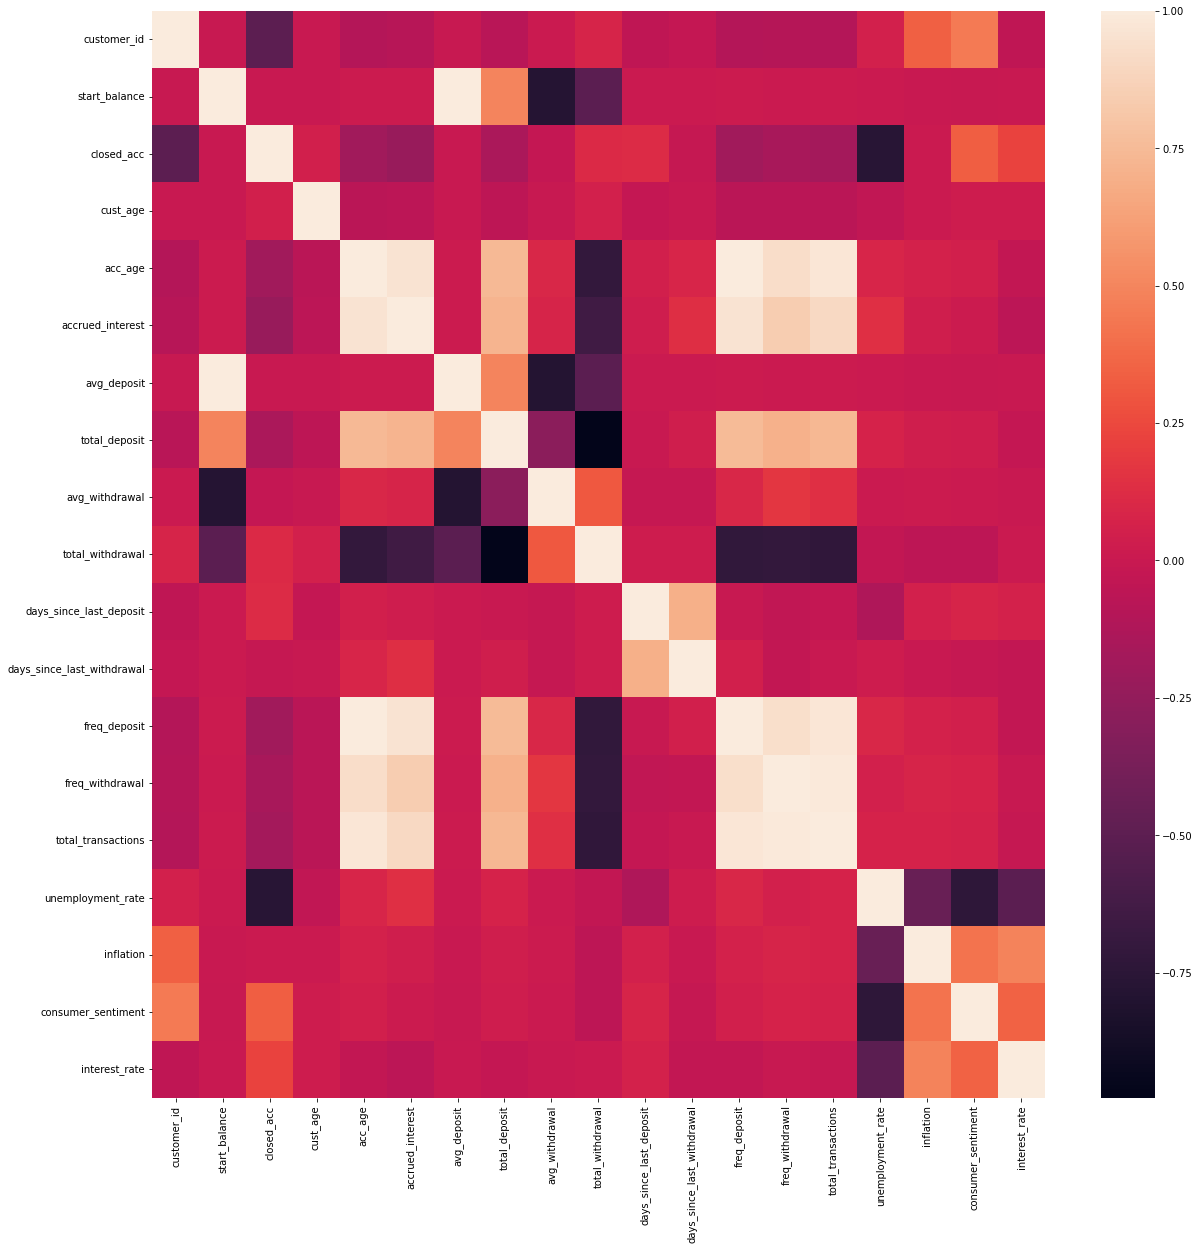

In [22]:
fig, axes=plt.subplots(figsize=(20,20))
sns.heatmap(corr, ax=axes)

Using correlation, we would choose the highest features that aren't correlated to each other which would be account_id, unemployment_rate, and accrued interest. These 3 would be our vector of features

Normalizing the feature allows the data to be intepreted on a common scale

In [23]:
def z_score_norm(s):
    new_s = (s-s.mean())/(s.std())
    return new_s

def min_max_norm(s):
    new_s=(s-s.min())/(s.max()-s.min())
    return(new_s)

customer_df['customer_id'] = min_max_norm(customer_df['customer_id'])
customer_df['unemployment_rate'] = min_max_norm(customer_df['unemployment_rate'])
customer_df['accrued_interest'] = min_max_norm(customer_df['accrued_interest'])




## 5. **Model Selection**

Given that we're trying to predict if they will churn or not, we'll be dealing with supervised classification models. The most common ones are Decisions Trees, Logistic Regression, Deep Learning

## 6. **Model Training/Testing**

### First Model we'll be using is Logistic Regression model

Split the data into a training/testing/validating set <br>
70% training, 15% testing, 15% validating

In [24]:
from sklearn.model_selection import train_test_split
customer_df_train, customer_df_test = train_test_split(customer_df, test_size=0.3, random_state=0)          #splits data to 7:3 ratio
customer_df_test, customer_df_validation = train_test_split(customer_df, test_size=0.5, random_state=0)     #splits the 3 of 7:3 into 1.5:1.5

X_train = customer_df_train[['customer_id','unemployment_rate','accrued_interest']]
y_train = customer_df_train['closed_acc']
display(X_train)

X_validation = customer_df_validation[['customer_id','unemployment_rate','accrued_interest']]
y_validation = customer_df_validation['closed_acc']
display(X_validation)

X_test = customer_df_test[['customer_id','unemployment_rate','accrued_interest']]
y_test = customer_df_test['closed_acc']
display(X_test)



,customer_id,unemployment_rate,accrued_interest
65690,0.385983,0.392857,0.031250
46696,0.852999,0.866071,0.125000
14402,0.298182,0.491071,0.000000
86603,0.537707,0.285714,0.015625
23453,0.329894,0.419643,0.000000
...,...,...,...
21243,0.185927,0.535714,0.031250
45891,0.830312,0.866071,0.171875
42613,0.685406,0.866071,0.312500
43567,0.742813,0.866071,0.281250


,customer_id,unemployment_rate,accrued_interest
52226,0.945558,0.866071,0.062500
72441,0.614914,0.151786,0.031250
40328,0.565126,0.187500,0.015625
73493,0.521752,0.285714,0.031250
20430,0.013662,0.339286,0.093750
...,...,...,...
83963,0.789196,0.044643,0.031250
75891,0.582495,0.214286,0.015625
66456,0.407153,0.366071,0.031250
144,0.048960,0.080357,0.000000


,customer_id,unemployment_rate,accrued_interest
10795,0.125443,0.562500,0.031250
97559,0.651668,0.142857,0.000000
84978,0.132002,0.187500,0.375000
84013,0.805065,0.044643,0.046875
25030,0.103876,0.500000,0.234375
...,...,...,...
21243,0.185927,0.535714,0.031250
45891,0.830312,0.866071,0.171875
42613,0.685406,0.866071,0.312500
43567,0.742813,0.866071,0.281250


Train the Logistic Regression model

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)                        #train the model
y_pred = logreg.predict(X_validation)                     #predicting using the validation set


We can find the coefficients, accuracy score, and a bunch of other useful calculations to see how effective the model is

logreg.coef_: [[-10.60573525  -8.10446112 -10.59581007]]
logreg.intercept_: [14.96403715]
Accuracy score is 0.9912833457424591
Precision is 1.0
Recall is 0.9898223145752937
F1 score is 0.9948851285111462
ROC AUC is 0.9949111572876468
[[ 7905     0]
 [  480 46682]]


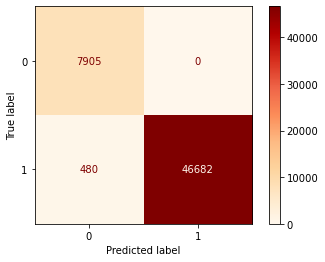

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


print(f"logreg.coef_: {logreg.coef_}")
print(f"logreg.intercept_: {logreg.intercept_}")

acc_score = accuracy_score(y_validation, y_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_validation, y_pred)                        #how accurate the prediction was out of the predicted values
print(f'Precision is {pr}')

re = recall_score(y_validation, y_pred)                           #how much did the prediction encapsulate 
print(f'Recall is {re}')

f1 = f1_score(y_validation, y_pred)                               #more balanced accuracy score
print(f'F1 score is {f1}')

roc_auc = roc_auc_score(y_validation, y_pred)                     #how good the model is 
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_validation, y_pred)
print(cm)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")

Find our final metrics with the test set

logreg.coef_: [[-10.60573525  -8.10446112 -10.59581007]]
logreg.intercept_: [14.96403715]
Accuracy score is 0.9914647877092942
Precision is 1.0
Recall is 0.9900046786610522
F1 score is 0.9949772372667621
ROC AUC is 0.9950023393305261
[[ 8044     0]
 [  470 46552]]


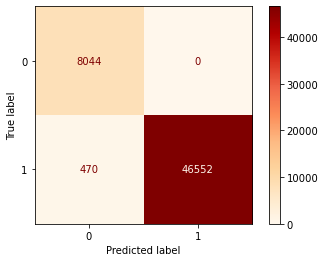

In [27]:
y_pred = logreg.predict(X_test) 

print(f"logreg.coef_: {logreg.coef_}")
print(f"logreg.intercept_: {logreg.intercept_}")

acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_pred)                        #how accurate the prediction was out of the predicted values
print(f'Precision is {pr}')

re = recall_score(y_test, y_pred)                           #how much did the prediction encapsulate 
print(f'Recall is {re}')

f1 = f1_score(y_test, y_pred)                               #more balanced accuracy score
print(f'F1 score is {f1}')

roc_auc = roc_auc_score(y_test, y_pred)                     #how good the model is 
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_test, y_pred)
print(cm)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")

### Second Model we'll be using is Decision Tree Classifier

Create a new dataframe where both each side has an even classifer amount

In [28]:
def balance_df(df, col_name, col_val, random_seed=123):        # random_seed initialises a pseudo-random number generator
    mask = df[col_name]==col_val
    df1 = df[mask]
    df2 = df[~mask]                                            # ~ is called 'tilde' and it's the complement operator 
    
    n_df1 = df1.shape[0]                                       # recall -- .shape returns the dimensions of a df as a tuple
    n_df2 = df2.shape[0]                                       # .shape[0] returns the number of rows in a dataframe
    
    if n_df1 > n_df2:
        df1 = df1.sample(n_df2, random_state=random_seed)      # df.sample() returns a random sample of items from an object
    else:
        df2 = df2.sample(n_df1, random_state=random_seed)

    out_df = pd.concat([df1, df2])                             # recall -- .concat() vertically stacks two dataframes together
    return out_df 

balanced_customer_df=balance_df(customer_df,'closed_acc',1)
balanced_customer_df['closed_acc'].value_counts()
balanced_customer_df.head()

,customer_id,dob,state,start_balance,creation_date,last_date,closed_acc,cust_age,last_trans_date,acc_age,...,days_since_last_deposit,days_since_last_withdrawal,freq_deposit,freq_withdrawal,total_transactions,index,unemployment_rate,inflation,consumer_sentiment,interest_rate
21873,0.145742,1991-03-14,New Jersey,6732.52,2009-05-31,2011-08-31,1,29,2011-08-31,27,...,61,150,20,32,52,2011-08-01,0.491071,1.656975,55.8,0.17
104740,0.832484,1952-07-12,Ohio,6265.36,2017-11-30,2018-11-30,1,67,2018-11-30,12,...,0,28,9,22,31,2018-11-01,0.026786,2.472599,97.5,2.20
19907,0.046236,1972-03-19,Arizona,11706.76,2007-01-31,2007-12-31,1,48,2007-12-31,11,...,0,18,8,4,12,2007-12-01,0.133929,2.712734,75.5,4.66
17194,0.049150,1973-12-09,California,7214.24,2007-01-31,2009-06-30,1,46,2009-06-30,29,...,0,1,28,38,66,2009-06-01,0.535714,2.089895,70.8,0.21
72696,0.668442,1943-04-20,Florida,5867.40,2015-06-30,2015-07-31,1,77,2015-07-31,1,...,0,40,2,3,5,2015-07-01,0.151786,2.141448,93.1,0.13


Of the newly balanced dataframe, split the dataset into training and test set

In [29]:
from sklearn.tree import DecisionTreeClassifier

bal_cust_df_train, bal_cust_df_test = train_test_split(balanced_customer_df, test_size=0.2, random_state=0)
features = ['customer_id','unemployment_rate', 'accrued_interest']

X_train = bal_cust_df_train[features]
y_train = bal_cust_df_train['closed_acc']

X_test = bal_cust_df_test[features]
y_test = bal_cust_df_test['closed_acc']



Train the Decision Tree model

In [30]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

Check your calculations for your model

Accuracy score is 1.0
Precision is 1.0
Recall is 1.0
F1 score is 1.0
ROC AUC is 1.0


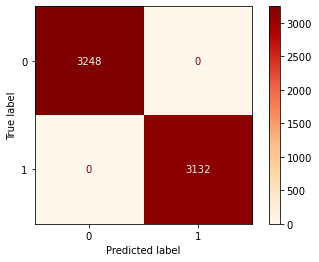

In [31]:
acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_pred)
print(f'Recall is {re}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score is {f1}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")


### Decision Tree pt2 Random Forest

Random Forest takes decision trees, but iterates through multiple variations of the tree just like how a forest has multiple trees

Split Data into Train, Test, and Validation sets because we have hyperparameters we can change

In [32]:
from sklearn.model_selection import GridSearchCV       
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=0)      

df_train, df_test = train_test_split(balanced_customer_df, test_size=0.2, random_state=0)
df_validation, df_test = train_test_split(balanced_customer_df, test_size=0.5, random_state=0)
features = ['customer_id', 'accrued_interest', 'unemployment_rate']

X_train = df_train[features]
y_train = df_train['closed_acc']

X_validation = df_validation[features]
y_validation = df_validation['closed_acc']

X_test = df_test[features]
y_test = df_test['closed_acc']



Train our model

In [33]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 0, min_samples_leaf=5)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_validation)

Check the stats of our model

Accuracy score is 0.9963007085083704
Precision is 1.0
Recall is 0.9926102204408818
F1 score is 0.9962914073794708
ROC AUC is 0.9963051102204409


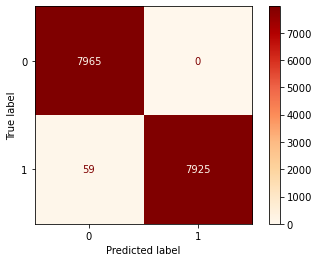

In [34]:
acc_score = accuracy_score(y_validation, y_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_validation, y_pred)
print(f'Precision is {pr}')

re = recall_score(y_validation, y_pred)
print(f'Recall is {re}')

f1 = f1_score(y_validation, y_pred)
print(f'F1 score is {f1}')

roc_auc = roc_auc_score(y_validation, y_pred)
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_validation, y_pred)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")

Use Grid Search for hyperparameter tuning and predict using our new hyperparameterised model


In [35]:
parameters = {'max_depth':        [2,3,4,5,6,7,8,9,10],                                  # pass ranges for hyperparameters
              'min_samples_leaf': [5, 10, 100, 0.01, 0.02, 0.04, 0.06, 0.1, 0.2, 0.5]}  

rfc=RandomForestClassifier(random_state=0)   

clf = GridSearchCV(estimator = rfc, param_grid = parameters, cv=5)                       # pass model and paratements for search
clf.fit(X_train, y_train)                                                                # fit selected model                  
y_pred = clf.predict(X_validation)                                                             # make predictions
print(y_pred)
best_depth = clf.best_estimator_.max_depth                                               # access best_estimator parameters
best_min_samples = clf.best_estimator_.min_samples_leaf           

print(f'best estimator: depth {best_depth} and min_samples {best_min_samples}')

[1 1 1 ... 1 1 1]
best estimator: depth 7 and min_samples 5


Predict using our new hyperparameterised model

In [36]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 0, min_samples_leaf=5)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Check the stats of the model

Accuracy score is 0.999811900432629
Precision is 1.0
Recall is 0.9996233521657251
F1 score is 0.9998116406102844
ROC AUC is 0.9998116760828626


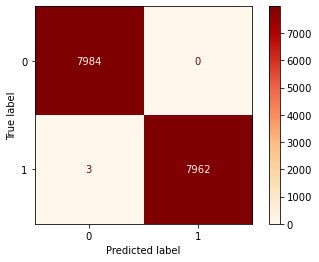

In [37]:
acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_pred)
print(f'Recall is {re}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score is {f1}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")

### Deep Learning Model

Using the balanced dataset established earlier in the Decision Tree model, we'll split it into a training set, validation set, and test set once again

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.losses import BinaryCrossentropy

nn_cust_df_train, nn_cust_df_test = train_test_split(balanced_customer_df, test_size=0.2, random_state=0)
nn_cust_df_validation, nn_cust_df_test = train_test_split(balanced_customer_df, test_size=0.5, random_state=0)
features = ['customer_id','unemployment_rate', 'accrued_interest']

X_train = nn_cust_df_train[features]
y_train = nn_cust_df_train['closed_acc']

X_validation = nn_cust_df_validation[features]
y_validation = nn_cust_df_validation['closed_acc']

X_test = nn_cust_df_test[features]
y_test = nn_cust_df_test['closed_acc']



Create the neural network model

In [39]:

model= Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],), activation='relu'))         #hidden layers and their activation function
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model= Sequential([Dense(3, input_shape=(X_train.shape[1],), activation='relu'),
Dense(3, activation='relu'),
Dense(1, activation='sigmoid')])

Train it on the Neural Network model

In [40]:


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
798/798 [==============================] - 2s 1ms/step - loss: 0.4926 - accuracy: 0.8342
Epoch 2/5
798/798 [==============================] - 2s 2ms/step - loss: 0.1785 - accuracy: 0.9954
Epoch 3/5
798/798 [==============================] - 1s 1ms/step - loss: 0.1014 - accuracy: 0.9954
Epoch 4/5
798/798 [==============================] - 1s 1ms/step - loss: 0.0682 - accuracy: 0.9954
Epoch 5/5
798/798 [==============================] - 1s 1ms/step - loss: 0.0505 - accuracy: 0.9954


Predict using validation set

In [41]:
y_pred=model.predict(X_validation)
print(y_pred)

y_pred=np.round(y_pred)
accuracy = accuracy_score(y_validation, y_pred)
print('Accuracy:', accuracy)

test_loss, test_acc = model.evaluate(X_validation, y_validation, verbose=0)
print('Test accuracy:', test_acc)

499/499 [==============================] - 1s 861us/step
[[0.99959624]
 [0.99843955]
 [0.99991316]
 ...
 [0.999356  ]
 [0.99821746]
 [0.9974755 ]]
Accuracy: 0.9961753087967897
Test accuracy: 0.9961752891540527


Hyperparameter tuning. Changing the number of layer, learning rate, epoch size, batch size

In [42]:

model= Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.fit(X_train, y_train, epochs=3)

Epoch 1/3
798/798 [==============================] - 3s 2ms/step - loss: 0.2295 - accuracy: 0.9598
Epoch 2/3
798/798 [==============================] - 1s 2ms/step - loss: 0.0300 - accuracy: 0.9954
Epoch 3/3
798/798 [==============================] - 1s 2ms/step - loss: 0.0281 - accuracy: 0.9954


Final Prediction on test set + statistics of model

499/499 [==============================] - 1s 1ms/step
Accuracy score is 0.9947959119694024
Precision is 1.0
Recall is 0.989579409918393
F1 score is 0.994762415599167
ROC AUC is 0.9947897049591965


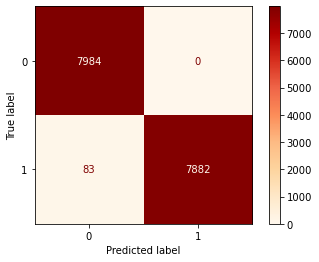

In [43]:
y_pred=model.predict(X_test)
y_pred=np.round(y_pred)

acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_pred)
print(f'Recall is {re}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score is {f1}')

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")

### Plans for Future/What to do differently

Looking at these created model, the accuracy for each of these model were way too high. The highest a model could go predictively is alledgely around 85% maximum so our near perfect model definitely has something wrong. As I was completeing this notebook, I've realized that my definition of churn is definitely off. It's seemingly too broad of a definition as my definition of churn would make transaction data obsolete because once an account is terminated, their entire transaction data is marked as churned. Using the transaction data wouldn't yield any correlation as all the features would have different ranges of values without a clear direction. The only set of data that would be used is the customer data. 

Definitely for next time, I'd need to have a better definition of churn, do more feature engineering/analysis, and have better feature selection. Afterwords, I'd go through an iterative process of going through the model-> going back to feature engineering-> go back to the model-> hyperparameterizing the paramaters-> back to feature engineering until the accuracy is satisfactory

I think I have the right idea of data cleansing, feature engineering, model selection, and model training, but having a poor definition from the bat of what you're trying to be predictive of really screws up any of the next steps. 

If I were to keep this definition, I would have to remove customer_id as a feature because, after testing the models without it, the results seems more normal. Inaccurate still, but inaccurate is more likely than perfectly accurate. I'd do some more feature engineering to find better features related to the definition.